<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> RANDOM FOREST + PCA + UNDERSAMPLING </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para aplicar el modelo: Random Forest
from sklearn.model_selection import GridSearchCV           # grid de parámetros definido
from sklearn.model_selection import RandomizedSearchCV     # grid de parámetros aleatorios sobre una determinada
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Definición de funciones  
A continuación, definimos una función que se encargará de hacer ajuste de parámetros del algoritmo, de acuerdo a los parámetros pasados como argumento, y que mostrará un informe con los resultados obtenidos.

In [2]:
def doGridSearch(model, grid, scores, X_train, y_train, X_test, y_test, columns, indices):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf=GridSearchCV(model, grid, cv=3, scoring='%s' % score, iid=False)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()

        means=clf.cv_results_['mean_test_score']
        stds =clf.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

        conf=pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=columns,
            index  =indices
        )
        print(conf)
        
        return clf.best_estimator_

## Importar DataSets
Importamos los datasets Train-Test y Evaluación para los que se ha aplicado PCA y submuestreo para ajustar la distribución de la clase mayoritaria.

In [3]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## TrainTest

In [4]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_over_pca.csv',Filename = '/tmp/train_test_over_pca.csv')

In [5]:
#Leemos el fichero y lo metemos en un dataframe.
trainTestPca = pd.read_csv('/tmp/train_test_over_pca.csv', dtype={'rank':'category'})

In [6]:
print (trainTestPca.shape)

(470000, 5)


In [7]:
trainTestPca.head()

,PC0,PC1,PC2,PC3,isFraud
0,-2.587585e+06,-438516.040597,16731.941171,42054.210743,1.0
1,-2.575372e+06,-454458.727901,-2238.486050,34600.500662,1.0
2,-2.587410e+06,-434868.610206,14605.315321,40424.161792,1.0
3,-2.572303e+06,-454589.613548,-8860.983138,31203.969577,1.0
4,-2.586258e+06,-410799.738130,572.015144,29667.701638,1.0


In [8]:
pd.value_counts(trainTestPca['isFraud'])

0.0    420800
1.0     49200
Name: isFraud, dtype: int64

In [9]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_over_pca.csv

## Evaluacion

In [10]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_over_pca.csv',Filename = '/tmp/eval_over_pca.csv')

In [11]:
#Leemos el fichero y lo metemos en un dataframe.
evalPca = pd.read_csv('/tmp/eval_over_pca.csv', dtype={'rank':'category'})

In [12]:
print (evalPca.shape)

(80000, 5)


In [13]:
evalPca.head()

,PC0,PC1,PC2,PC3,isFraud
0,5.207935e+06,1.624910e+07,-1.693150e+05,-2.303496e+06,1.0
1,-8.297775e+05,6.762575e+04,-9.888326e+04,-6.125622e+04,1.0
2,-2.422555e+06,3.008502e+06,-1.993044e+06,-1.498430e+06,1.0
3,-2.585197e+06,-3.886420e+05,-1.234703e+04,1.976531e+04,1.0
4,-2.585782e+06,-4.008621e+05,-5.222108e+03,2.522653e+04,1.0


In [14]:
pd.value_counts(evalPca['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [15]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_over_pca.csv

## Random Forest
En este caso, para el modelo de Random Forest no es necesario aplicar normalización en los datos puesto que este tipo de modelos no se ven afectados por los ordenes de magnitud de los atributos.

### Entrenamiento y test del modelo

In [16]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
y = trainTestPca.loc[:, 'isFraud'].values
X = trainTestPca.drop(columns=['isFraud']).values

In [17]:
# Creamos los conjuntos de entrenamiento y test:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Verificamos los tamaños de los df:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((329000, 4), (141000, 4), (329000,), (141000,))

In [20]:
# Creamos la malla de parámetros con los que se evaluará el algoritmo Random Forest
    # n_estimators --> numero de arboles de decision del modelo
    # max_features --> numero de elementos que va a utilizar el RandomForest
    # max depth --> Numero máximo de profundidad del arbol ( numero de niveles)
tuned_parameters={'n_estimators': [10, 50, 100, 200, 500],
                  'max_features': ['auto', 'sqrt', 0.5, 0.7, 0.9, None],
                  'max_depth'   : [5,10, 15,20]}

In [19]:
# Ejecutamos el modelo sobre los datos:
randomForestUnderPca = doGridSearch(RandomForestClassifier(),
                          tuned_parameters, 
                          ['recall'],
                          X_train, y_train, X_test, y_test,
                          ['Predicted 0', 'Predicted 1'], ['True 0', 'True 1'])

# Tuning hyper-parameters for recall



/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters set found on development set:

{'max_depth': 20, 'max_features': None, 'n_estimators': 500}

Grid scores on development set:

0.783 (+/-0.043) for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}
0.773 (+/-0.020) for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}
0.775 (+/-0.014) for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
0.775 (+/-0.013) for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.774 (+/-0.011) for {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.778 (+/-0.028) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
0.778 (+/-0.013) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
0.782 (+/-0.010) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
0.779 (+/-0.016) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
0.778 (+/-0.016) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
0.777 (+/-0.028) for {'max_depth

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    126109
         1.0       0.97      0.97      0.97     14891

    accuracy                           0.99    141000
   macro avg       0.98      0.98      0.98    141000
weighted avg       0.99      0.99      0.99    141000


        Predicted 0  Predicted 1
True 0       125677          432
True 1          501        14390


{'max_depth': 20, 'max_features': None, 'n_estimators': 500}

In [18]:
randomForestUnderPca = RandomForestClassifier(n_estimators=500, max_depth=20,max_features=None)

In [19]:
randomForestUnderPca.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=None, n_estimators=500)

In [20]:
randomForestUnderPca.score(X_train, y_train), randomForestUnderPca.score(X_test, y_test)

(0.999258358662614, 0.9932836879432624)

In [21]:
randomForestUnderPca_pred = randomForestUnderPca.predict(X_test)

In [22]:
# Matriz de confusión
cm=confusion_matrix(y_test, randomForestUnderPca_pred)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,125665,444
1_true,503,14388


In [23]:
# Podemos ver un informe más completo del clasificador con la métrica classification_report:
print(classification_report(y_test, randomForestUnderPca_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    126109
         1.0       0.97      0.97      0.97     14891

    accuracy                           0.99    141000
   macro avg       0.98      0.98      0.98    141000
weighted avg       0.99      0.99      0.99    141000



donde,  
`precision` es la especificidad: TP/(TP+FN) (positivos predichos sobre el total de positivos)  
`recall` es el Valor predictivo positivo: TP/(TP+FP) (acierto de los predichos como positivos)  
`support` indica el número de muestras en cada clase en el conjunto de test (suma por filas en la matriz de confusión)

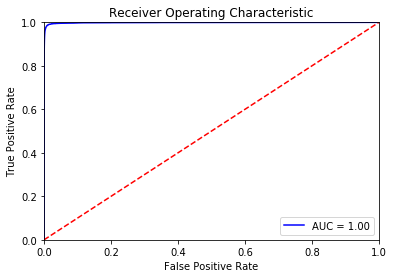

In [24]:
# Área bajo la curva ROC:  
    # Para calcular el área bajo la curva ROC (AUC) es necesario obtener
    # la probabilidad de salida del clasificador con `predict_proba`
prediccion_prob = randomForestUnderPca.predict_proba(X_test)
#la primera columna corresponde a la etiqueta 'N'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta N)
roc_auc_score((y_test==0), prediccion_prob[:,0])

probs = randomForestUnderPca.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Clasificación de nuevos valores 
Aplicamos el modelo al dataframe de evaluación:

In [25]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
evaly = evalPca.loc[:, 'isFraud'].values
evalX = evalPca.drop(columns=['isFraud']).values

In [26]:
# Aplicamos el modelo
randomForestUnderPca.score(evalX, evaly)

0.9964125

In [27]:
# Calculamos la predicción
predEval = randomForestUnderPca.predict(evalX)

In [28]:
# Matriz de confusión
cm=confusion_matrix(evaly, predEval)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,78933,267
1_true,20,780


In [29]:
pru = np.where(predEval > 0.4,1,0)
print(classification_report(evaly, pru))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     79200
         1.0       0.74      0.97      0.84       800

    accuracy                           1.00     80000
   macro avg       0.87      0.99      0.92     80000
weighted avg       1.00      1.00      1.00     80000



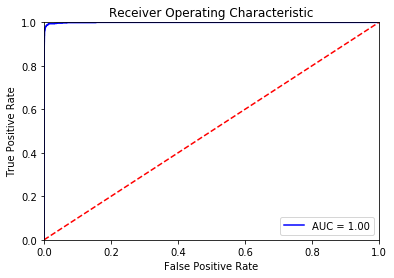

In [30]:
# Curva ROC
probs_eval = randomForestUnderPca.predict_proba(evalX)
preds_eval = probs_eval[:,1]
fpr_eval, tpr_eval, threshold_eval = metrics.roc_curve(evaly, preds_eval)
roc_auc_eval = metrics.auc(fpr_eval, tpr_eval)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_eval, tpr_eval, 'b', label = 'AUC = %0.2f' % roc_auc_eval)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Guardamos la predicción
Guardamos la predicción realizada en el dataframe de Evaluación:

In [32]:
predRF = pd.DataFrame(predEval, columns = ["RFOverPCA_pred"])
modelResult = pd.concat([evalPca, predRF["RFOverPCA_pred"]],axis = 1)
modelResult.head()

,PC0,PC1,PC2,PC3,isFraud,RFOverPCA_pred
0,5.207935e+06,1.624910e+07,-1.693150e+05,-2.303496e+06,1.0,1.0
1,-8.297775e+05,6.762575e+04,-9.888326e+04,-6.125622e+04,1.0,1.0
2,-2.422555e+06,3.008502e+06,-1.993044e+06,-1.498430e+06,1.0,1.0
3,-2.585197e+06,-3.886420e+05,-1.234703e+04,1.976531e+04,1.0,1.0
4,-2.585782e+06,-4.008621e+05,-5.222108e+03,2.522653e+04,1.0,1.0


In [34]:
pd.crosstab(index=modelResult['isFraud'],columns=modelResult['RFOverPCA_pred'], margins=True)

RFOverPCA_pred,0.0,1.0,All
isFraud,,,
0.0,78930,270,79200
1.0,21,779,800
All,78951,1049,80000


In [38]:
modelResult.to_csv('/tmp/eval_over_pca_pred_rf.csv', index = False)

In [39]:
s3.upload_file(Bucket = BUCKET_NAME, Key = 'eval_over_pca_pred_rf.csv', Filename = '/tmp/eval_over_pca_pred_rf.csv')

In [40]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_over_pca_pred_rf.csv